In [2]:
import pandas as pd
import numpy as np
import os
import pickle
from collections import Counter

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

In [6]:
from scipy import stats
from scipy.stats import norm, gamma, linregress, skew
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering 
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, confusion_matrix, silhouette_score, silhouette_samples

In [7]:
def dump_pickle(file, filename):
    outfile = open(filename, 'wb')
    pickle.dump(file, outfile)
    outfile.close()

def load_pickle(filename):
    infile = open(filename, 'rb')
    file = pickle.load(infile)
    infile.close()
    return file

In [8]:
sns.set()

## Data Prep

### Read Synergy + CTG Data

In [9]:
s_df = pd.read_csv('nba_offense_plus_ctg.csv')
s_df.shape

(3072, 65)

### Read BBR Data

In [10]:
bbr_df = pd.read_csv('bbr_nba_stats.csv')

In [11]:
mp_filter = bbr_df['mp'] >= 300
bbr_df = bbr_df[mp_filter]
bbr_df.shape

(2140, 39)

In [12]:
bbr_df['mp'].min()

300

### Merge Synergy Data & BBR Data

In [13]:
s_df['Player_Alt'] = s_df['Player'].apply(lambda x: x.replace(' ', '').lower())\
                                   .apply(lambda x: x.replace("'", ''))\
                                   .apply(lambda x: x.replace('.', ''))

In [14]:
bbr_df['player_alt_alt'] = bbr_df['player_alt'].apply(lambda x: x.replace(' ', ''))\
                                               .apply(lambda x: x.replace("'", ''))\
                                               .apply(lambda x: x.replace('.', ''))\
                                               .apply(lambda x: x.lower())

In [15]:
synergy_name_dict = {'kevinknoxii': 'kevinknox',
                     'danilogalinari': 'danilogallinari',
                     'louiswilliams': 'louwilliams',
                     'eneskanter': 'enesfreedom',
                     'terryrozieriii': 'terryrozier',
                     'cameronreddish': 'camreddish',
                     'jahilokafor': 'jahlilokafor',
                     'danuelhouse': 'danuelhousejr',
                     'alfarouqaminu': 'al-farouqaminu',
                     'nenehilario': 'nene',
                     'frankmason': 'frankmasoniii',
                     'larrynance': 'larrynancejr',
                     'wesleyiwundu': 'wesiwundu',
                     'robertwilliamsiii': 'robertwilliams',
                     'harrygilesiii': 'harrygiles',
                     'jamesennis': 'jamesennisiii',
                     'mohamedbamba': 'mobamba',
                     'xaviertillman': 'xaviertillmansr',
                     'patrickbeverly': 'patrickbeverley',
                     'malcomdelaney': 'malcolmdelaney',
                     'marcusmorrissr': 'marcusmorris',
                     'nicolasclaxton': 'nicclaxton',
                     'juanhernangomez': 'juanchohernangomez',
                     'guillermohernangomez': 'willyhernangomez',
                     'timothéluwawu-cabarrot': 'timotheluwawu-cabarrot',
                     'nahshonhyland': 'boneshyland',
                     'derrickwaltonjr': 'derrickwalton',
                     'ishmailwainright': 'ishwainright',
                     'johnnyobryantiii': 'johnnyobryant'}

In [16]:
s_df['Player_Alt'] = s_df['Player_Alt']\
                     .apply(lambda x: synergy_name_dict.get(x, x))

In [17]:
df = s_df.merge(bbr_df, how='right', 
                left_on=['Player_Alt', 'Team', 'Season'],
                right_on=['player_alt_alt', 'team', 'Season'])
df = df[~df['player_alt_alt'].isna()].reset_index().drop('index', axis=1)
df.shape

(2141, 105)

In [18]:
# Fix Gerald Green Rockets 18-19
conds = ((df['Player'] == 'Gerald Green') & 
         (df['Season'] == '2018-2019') &
         (df['GP'] == 2))
df = df[~conds].reset_index(drop=True)
df.shape

(2140, 105)

In [19]:
# check 
df[['Player_Alt', 'Team', 'Season']].drop_duplicates().shape

(2140, 3)

## Clustering

### Functions

In [20]:
def plot_pca_explained_var(x):
    ev_list = []
    c_list = list(range(2, 12))
    for c in c_list:
        pca = PCA(n_components=c)
        ev_list.append(np.sum(pca.fit(x).explained_variance_ratio_))
    
    # Plot
    plt.plot(c_list, ev_list)
    plt.hlines(0.95, 2, 11, color='red', linestyle='--')
    plt.xlabel('Number of Components (c)')
    plt.ylabel('Explained Variance Ratio')
    plt.title('PCA Results')

In [21]:
def plot_silhouette_score(x):
    avg_ss_list = []
    k_list = list(range(2, 16))
    for k in k_list:
        sc = SpectralClustering(n_clusters=k, 
                                affinity='nearest_neighbors', 
                                random_state=42)
        cluster_labels = sc.fit(x).labels_
        avg_silhouette_score = silhouette_score(x, cluster_labels)
        avg_ss_list.append(avg_silhouette_score)

    # Plot
    # Plot the elbow
    plt.plot(k_list, avg_ss_list, 'bx-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Average Silhouette Score')
    plt.title('The Silhouette Score Method Showing the Optimal k')

### Define Weight Columns

In [22]:
playtypes = ['Isolation', 'P&R Ball Handler', 'Post-Up', 
             'P&R Roll Man', 'Spot Up', 'Off Screen', 
             'Hand Off', 'Cut', 
             'Offensive Rebounds', 
             'Transition']
playtype_weights = [f'{playtype}_Poss%'
                    for playtype in playtypes]

In [23]:
situations = ['Pick and Rolls Including Passes',
              'Isolations Including Passes',
              'Post-Ups Including Passes']
situation_weights = [f'{situation}_On_Court%'
                     for situation in situations]

In [24]:
shottypes = ['Catch and Shoot', 
             'At Rim',
             'Long (3 point jump shots)',
             'All Jump Shots off the Dribble'
            ]
shottype_weights = [f'{shottype}_FGA%' 
                    for shottype in shottypes]

In [25]:
weights = playtype_weights + shottype_weights + situation_weights 
weights

['Isolation_Poss%',
 'P&R Ball Handler_Poss%',
 'Post-Up_Poss%',
 'P&R Roll Man_Poss%',
 'Spot Up_Poss%',
 'Off Screen_Poss%',
 'Hand Off_Poss%',
 'Cut_Poss%',
 'Offensive Rebounds_Poss%',
 'Transition_Poss%',
 'Catch and Shoot_FGA%',
 'At Rim_FGA%',
 'Long (3 point jump shots)_FGA%',
 'All Jump Shots off the Dribble_FGA%',
 'Pick and Rolls Including Passes_On_Court%',
 'Isolations Including Passes_On_Court%',
 'Post-Ups Including Passes_On_Court%']

### Check Correlations Among Weights

Text(0.5, 1.0, 'Correlations Among Weights in NBA (2017-2022)')

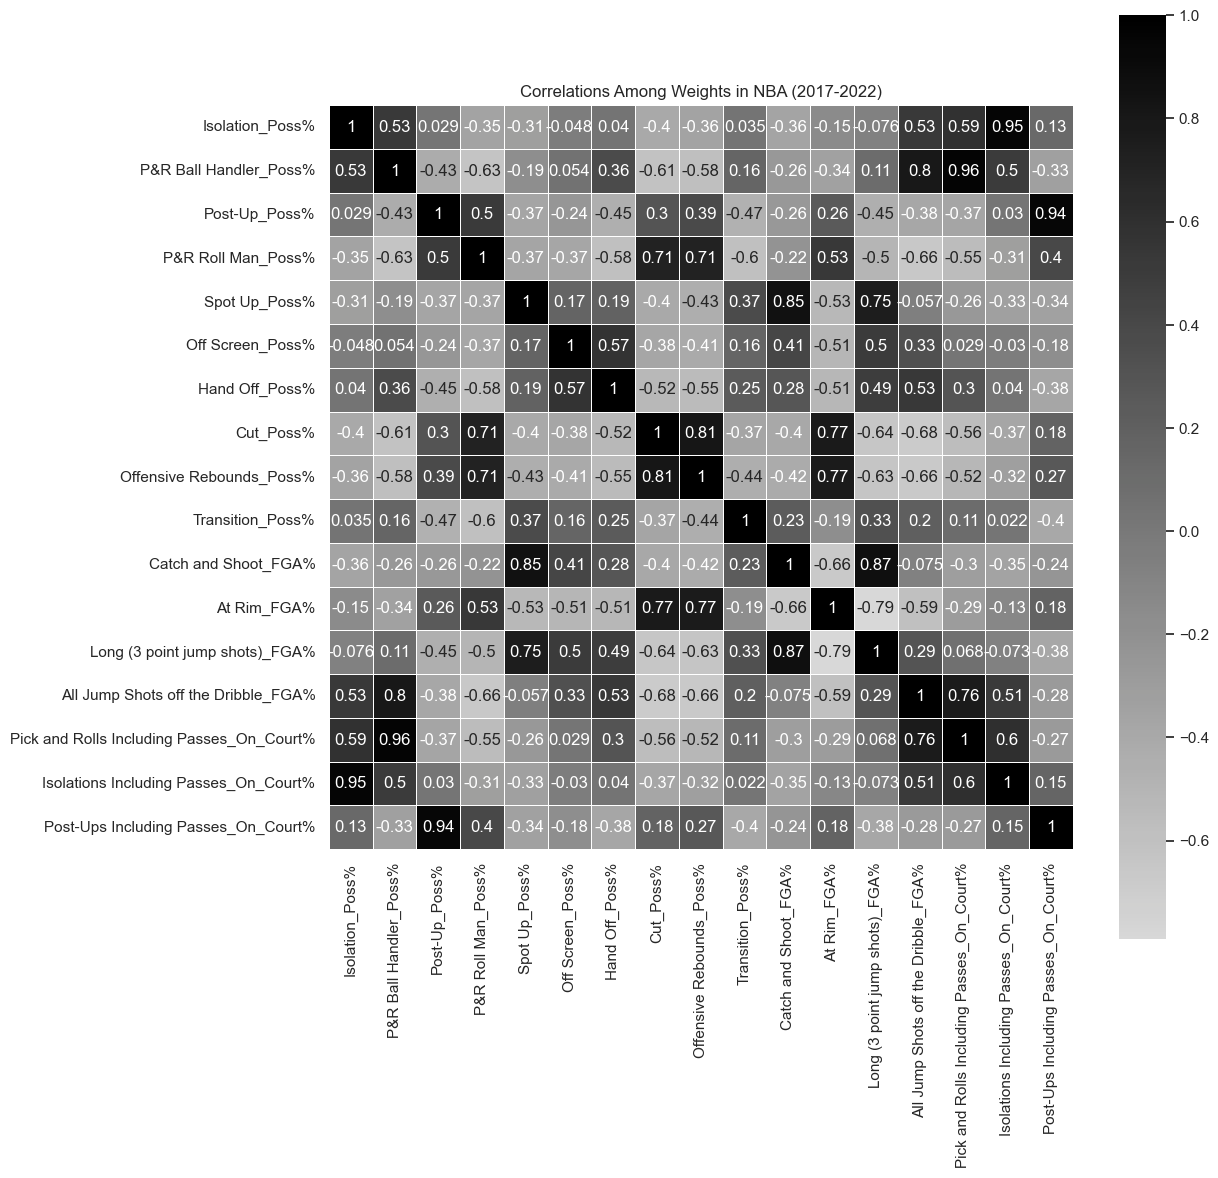

In [26]:
figsize(12, 8)
corr = df[weights].corr()
f, ax = plt.subplots(figsize=(12, 12))
cmap = sns.light_palette('black', as_cmap=True)
sns.heatmap(corr, 
            cmap=cmap, vmax=None, center=0,
            square=True, annot=True, linewidths=.5)
plt.title('Correlations Among Weights in NBA (2017-2022)')

### Reduce Dimensions with PCA

In [27]:
X = df[weights].copy()

Determine how many components reduce down to via PCA

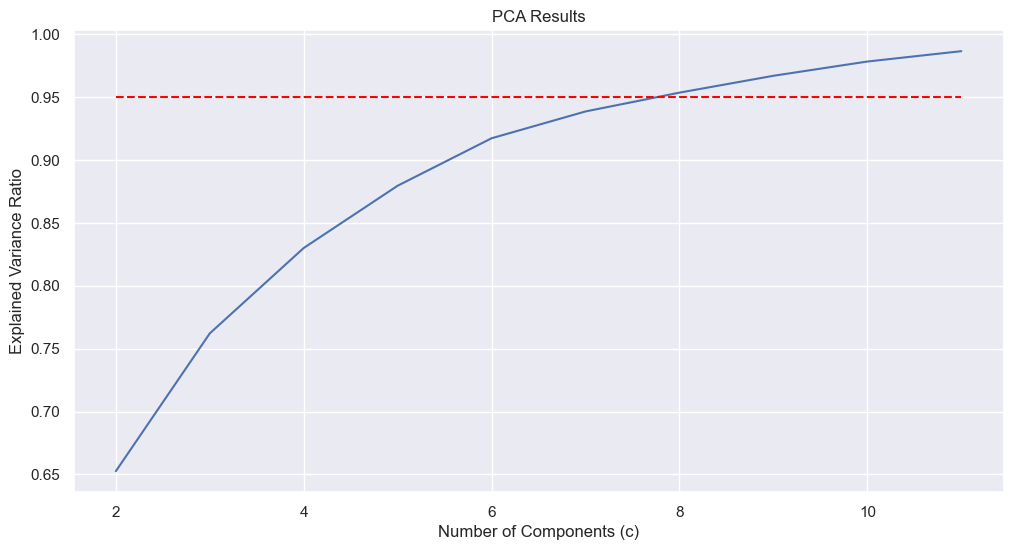

In [28]:
figsize(12, 6)
pre_pca_pipe = make_pipeline(RobustScaler(), StandardScaler())
# pre_pca_pipe = StandardScaler()
plot_pca_explained_var(pre_pca_pipe.fit_transform(X))

Choosse 8

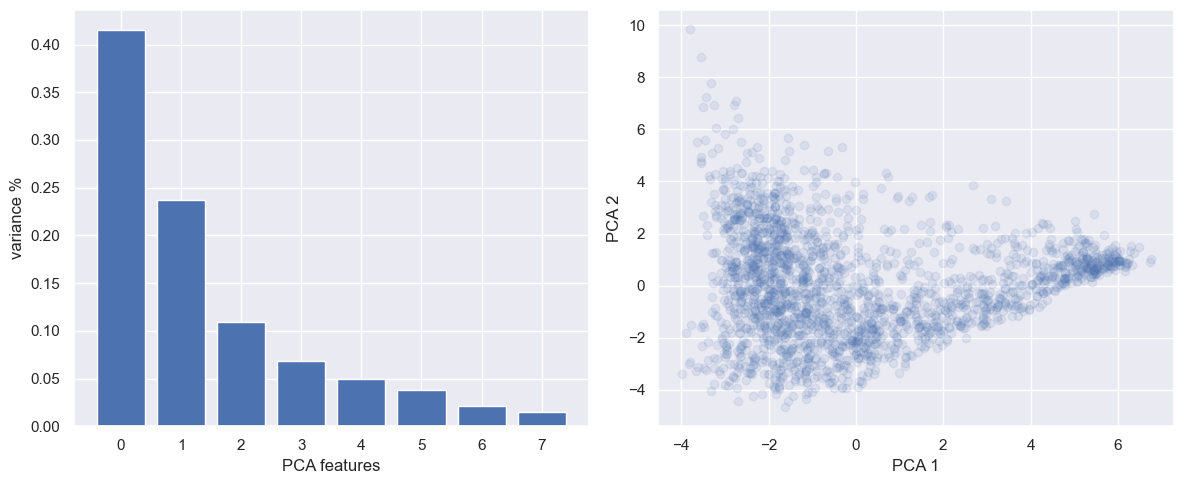

In [29]:
n_components = 8

pre_pca_pipe = make_pipeline(RobustScaler(), StandardScaler())
pca = PCA(n_components=n_components)
pca.fit(pre_pca_pipe.fit_transform(X))
pca_components = pca.transform(pre_pca_pipe.fit_transform(X))

figsize(12, 5)
plt.subplot(1, 2, 1)
plt.bar(range(pca.n_components_), pca.explained_variance_ratio_)
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(range(pca.n_components_))

plt.subplot(1, 2, 2)
plt.scatter(pca_components[:, 0], pca_components[:, 1], alpha=.1)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.tight_layout()

In [30]:
pre_cluster_scaler = StandardScaler()
X_transformed = pre_cluster_scaler.fit_transform(pca_components)

### Choose Optimal K

Determine # of clusters using silhouette score method

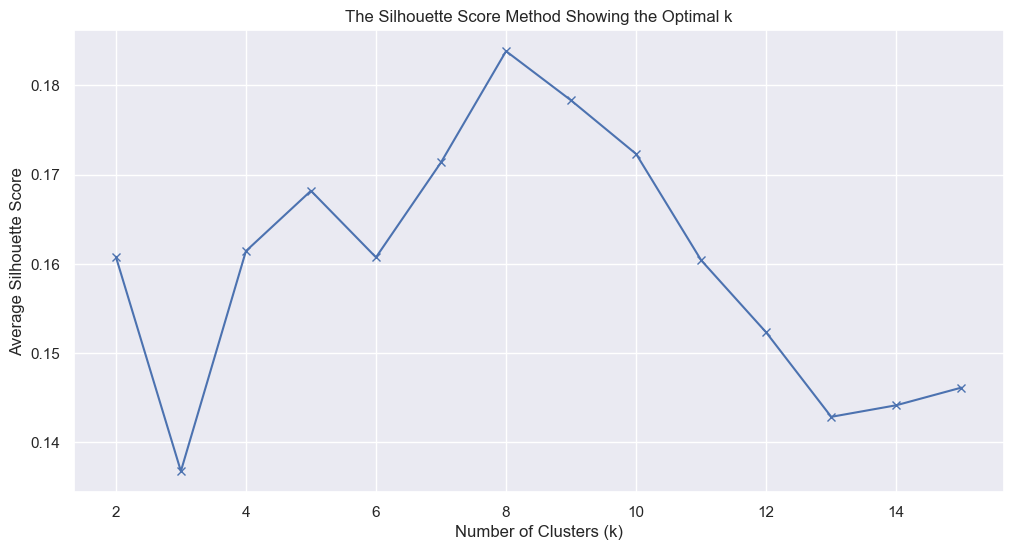

In [31]:
figsize(12, 6)
plot_silhouette_score(X_transformed)

### Clustering

In [32]:
# Choose k = 8
n_clusters = 8

sc = SpectralClustering(n_clusters=n_clusters, 
                        affinity='nearest_neighbors', 
                        random_state=42)
sc.fit(X_transformed)
df['player_cluster'] = sc.labels_
df['silhouette_coefficient'] = silhouette_samples(X_transformed, 
                                                  df['player_cluster'])
df.groupby('player_cluster').count()['Player']

player_cluster
0    511
1    189
2    171
3    256
4     50
5    782
6    101
7     80
Name: Player, dtype: int64

## Results

### Functions

In [33]:
def plot_cluster_res_2d(df, cluster_col, col1, col2, cluster_dict):
    clusters = list(set(df[cluster_col]))
    for cluster in clusters:
        cluster_cond = df[cluster_col] == cluster
        x = df[cluster_cond][col1].values * 100
        y = df[cluster_cond][col2].values * 100
        plt.scatter(x, y, 
                    label=f'Cluster {cluster}: {cluster_dict[cluster]}', 
                    alpha=0.3)
        plt.xlabel(col1)
        plt.ylabel(col2)
        plt.legend()

In [163]:
def show_cluster_res(df, cluster_col, weights=weights):
    cluster_res = df.groupby(cluster_col)[['usg_pct', 'obpm', 'onpm'] + weights]\
                    .mean().sort_values('obpm', ascending=False)
    cluster_cnt = Counter(df[cluster_col])
    cluster_res['obpm'] = cluster_res['obpm'].apply(lambda x: f'{x:.2f}')
    cluster_res['onpm'] = cluster_res['onpm'].apply(lambda x: f'{x:.2f}')
    cluster_res['usg_pct'] = cluster_res['usg_pct'].apply(lambda x: f'{x:.1f}%')
    for col in cluster_res.columns:
        if '%' in col or 'Rt' in col:
            cluster_res[col] = cluster_res[col].apply(lambda x: f'{x:.1%}')
    cluster_res = cluster_res.reset_index()
    cluster_res['#'] = cluster_res[cluster_col].map(cluster_cnt)
    return cluster_res.T

### Overview

In [164]:
show_cluster_res(df, 'player_cluster')

0      1      2      3      4  \
player_cluster                                 1      2      7      6      0   
usg_pct                                    26.4%  23.1%  14.9%  19.4%  20.6%   
obpm                                        2.04   1.26  -0.16  -0.19  -0.57   
onpm                                        2.46   0.71  -0.30   1.11  -0.28   
Isolation_Poss%                            16.9%   5.2%   1.1%   3.0%   6.9%   
P&R Ball Handler_Poss%                     27.3%   2.0%   0.1%  12.9%  37.0%   
Post-Up_Poss%                               5.2%  23.5%   7.5%   1.1%   0.7%   
P&R Roll Man_Poss%                          1.9%  17.7%  21.7%   1.3%   0.5%   
Spot Up_Poss%                              16.7%  15.6%   4.5%  27.6%  22.6%   
Off Screen_Poss%                            4.8%   2.2%   0.3%  20.5%   3.5%   
Hand Off_Poss%                              5.2%   1.1%   0.1%   9.5%   6.7%   
Cut_Poss%                                   3.4%  12.1%  28.3%   4.5%   2.9%   
Offensive Rebounds_Poss%                    2.6%  11.0%  28.1%   1.8%   1.9%   
Transition_Poss%                           15.9%   9.4%   8.4%  17.8%  17.2%   
Catch and Shoot_FGA%                       19.9%  22.9%   3.8%  47.5%  24.7%   
At Rim_FGA%                                32.1%  43.1%  79.9%  19.2%  29.6%   
Long (3 point jump shots)_FGA%             35.5%  20.4%   2.1%  58.6%  39.1%   
All Jump Shots off the Dribble_FGA%        31.5%   6.9%   1.0%  24.9%  31.6%   
Pick and Rolls Including Passes_On_Court%  14.8%   0.8%   0.0%   5.1%  16.7%   
Isolations Including Passes_On_Court%       6.3%   1.6%   0.2%   0.9%   2.2%   
Post-Ups Including Passes_On_Court%         2.2%   7.8%   1.5%   0.3%   0.2%   
#                                            189    171     80    101    511   

                                               5      6      7  
player_cluster                                 3      4      5  
usg_pct                                    16.8%  17.5%  16.5%  
obpm                                       -0.62  -0.84  -1.49  
onpm                                       -1.29   0.58  -1.01  
Isolation_Poss%                             1.9%   1.6%   3.5%  
P&R Ball Handler_Poss%                      0.4%  10.8%   8.7%  
Post-Up_Poss%                               6.9%   0.2%   2.9%  
P&R Roll Man_Poss%                         27.8%   1.3%   4.6%  
Spot Up_Poss%                              15.5%  29.0%  36.9%  
Off Screen_Poss%                            0.6%  12.9%   4.4%  
Hand Off_Poss%                              0.6%  21.8%   5.1%  
Cut_Poss%                                  21.6%   5.0%   8.3%  
Offensive Rebounds_Poss%                   14.6%   1.9%   5.6%  
Transition_Poss%                           10.1%  15.5%  20.0%  
Catch and Shoot_FGA%                       23.2%  49.2%  41.9%  
At Rim_FGA%                                54.3%  19.0%  34.0%  
Long (3 point jump shots)_FGA%             19.2%  60.7%  47.1%  
All Jump Shots off the Dribble_FGA%         3.0%  25.2%  14.0%  
Pick and Rolls Including Passes_On_Court%   0.1%   4.0%   3.0%  
Isolations Including Passes_On_Court%       0.4%   0.4%   0.9%  
Post-Ups Including Passes_On_Court%         1.7%   0.0%   0.7%  
#                                            256     50    782

- Ballhandler: 1 & 0
- Big: 2 & 7 & 3
- Wing: 6 & 4 & 5

In [165]:
cluster_dict = {1: 'Ballhandler', 0: 'Ballhandler',
                2: 'Big', 7: 'Big', 3: 'Big',
                6: 'Wing', 4: 'Wing', 5: 'Wing'}

In [166]:
def color_cluster(val, cluster_dict=cluster_dict):
    if cluster_dict[val] == 'Ballhandler':
        return '#AB3B3A'
    elif cluster_dict[val] == 'Wing':
        return '#2E5C6E'
    elif cluster_dict[val] == 'Big':
        return '#F7D94C'

In [167]:
def color_cluster_pandas(val, cluster_dict=cluster_dict):
    if val in cluster_dict.keys():
        color = color_cluster(val, cluster_dict=cluster_dict)
    else:
        color = 'white'
    return f'background-color: {color}' 

In [168]:
def color_obpm(val):
    if float(val) >= 0:
        return 'color: red; font-weight: bold'
    else:
        return 'color: blue; font-weight: bold'

In [170]:
show_cluster_res(df, 'player_cluster')\
.style\
.applymap(color_cluster_pandas, 
          subset=pd.IndexSlice[['player_cluster'], :])\
.applymap(color_obpm, 
          subset=pd.IndexSlice[['obpm'],:])\
.applymap(lambda x: 'background-color: #AB3B3A', 
          subset=pd.IndexSlice[['P&R Ball Handler_Poss%',
                                'All Jump Shots off the Dribble_FGA%',
                                'Pick and Rolls Including Passes_On_Court%'], 
                               [0, 4]])\
.applymap(lambda x: 'background-color: #F7D94C', 
          subset=pd.IndexSlice[['P&R Roll Man_Poss%',
                                'Post-Up_Poss%',
                                'Cut_Poss%',
                                'Offensive Rebounds_Poss%',
                                'At Rim_FGA%'], 
                               [1, 2, 5]])\
.applymap(lambda x: 'background-color: #2E5C6E', 
          subset=pd.IndexSlice[['Spot Up_Poss%',
                                'Catch and Shoot_FGA%',
                                'Long (3 point jump shots)_FGA%'], 
                               [3, 6, 7]])\
.applymap(lambda x: 'color: red; font-weight: bold',
          subset=pd.IndexSlice[['Post-Ups Including Passes_On_Court%'],
                               [0, 1]])\
.applymap(lambda x: 'background-color: #69B0AC',
          subset=pd.IndexSlice[['#'], [3, 5, 7]])

### Observations

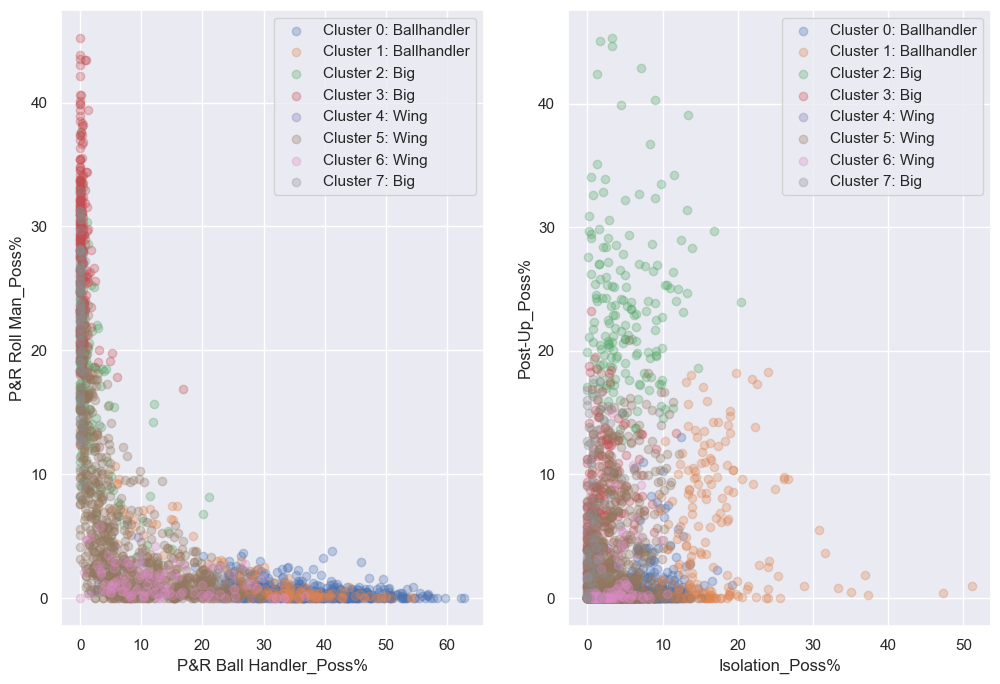

In [41]:
figsize(12, 8)
plt.subplot(1, 2, 1)
plot_cluster_res_2d(df, 
                    cluster_col='player_cluster', 
                    col1='P&R Ball Handler_Poss%', 
                    col2='P&R Roll Man_Poss%',
                    cluster_dict=cluster_dict)
plt.subplot(1, 2, 2)
plot_cluster_res_2d(df, 
                    cluster_col='player_cluster', 
                    col1='Isolation_Poss%', 
                    col2='Post-Up_Poss%',
                    cluster_dict=cluster_dict)

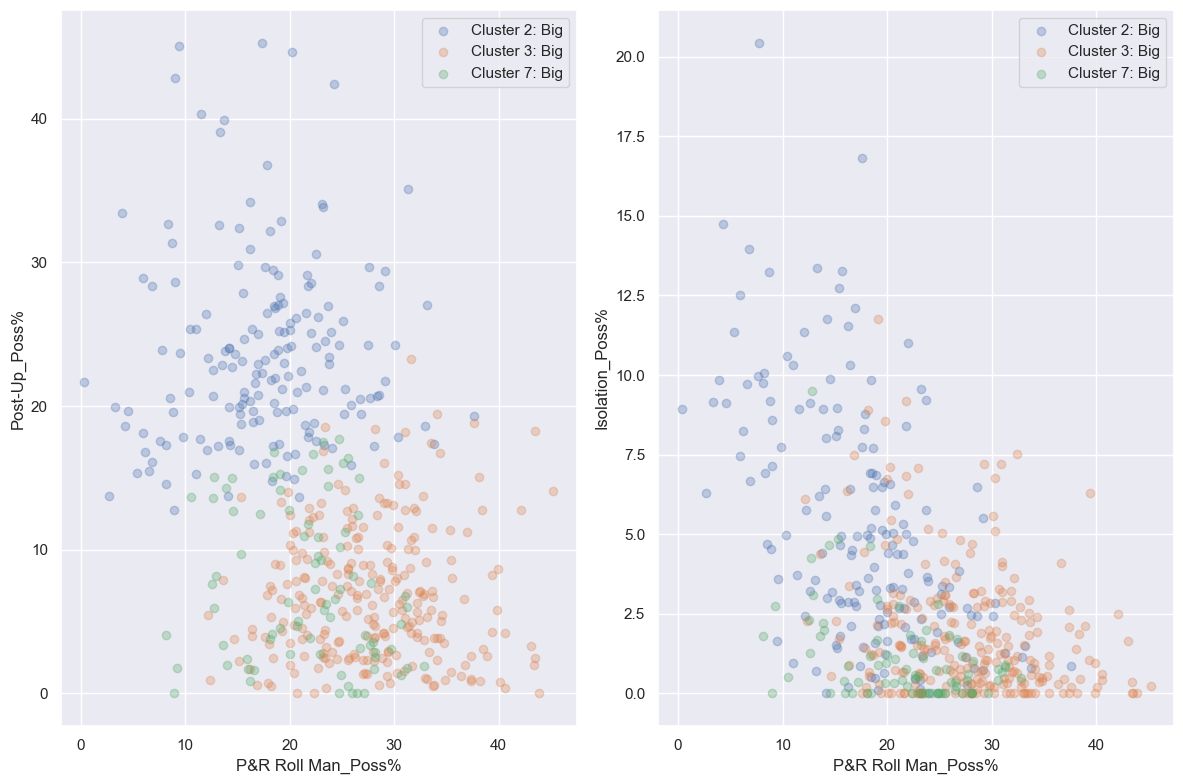

In [42]:
figsize(12, 8)
plt.subplot(1, 2, 1)
plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
                                                  for cluster in cluster_dict.keys() 
                                                  if cluster_dict[cluster] == 'Big'])], 
                    cluster_col='player_cluster', 
                    col1='P&R Roll Man_Poss%', 
                    col2='Post-Up_Poss%',
                    cluster_dict=cluster_dict)
plt.subplot(1, 2, 2)
plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
                                                  for cluster in cluster_dict.keys() 
                                                  if cluster_dict[cluster] == 'Big'])], 
                    cluster_col='player_cluster', 
                    col1='P&R Roll Man_Poss%', 
                    col2='Isolation_Poss%',
                    cluster_dict=cluster_dict)
plt.tight_layout()

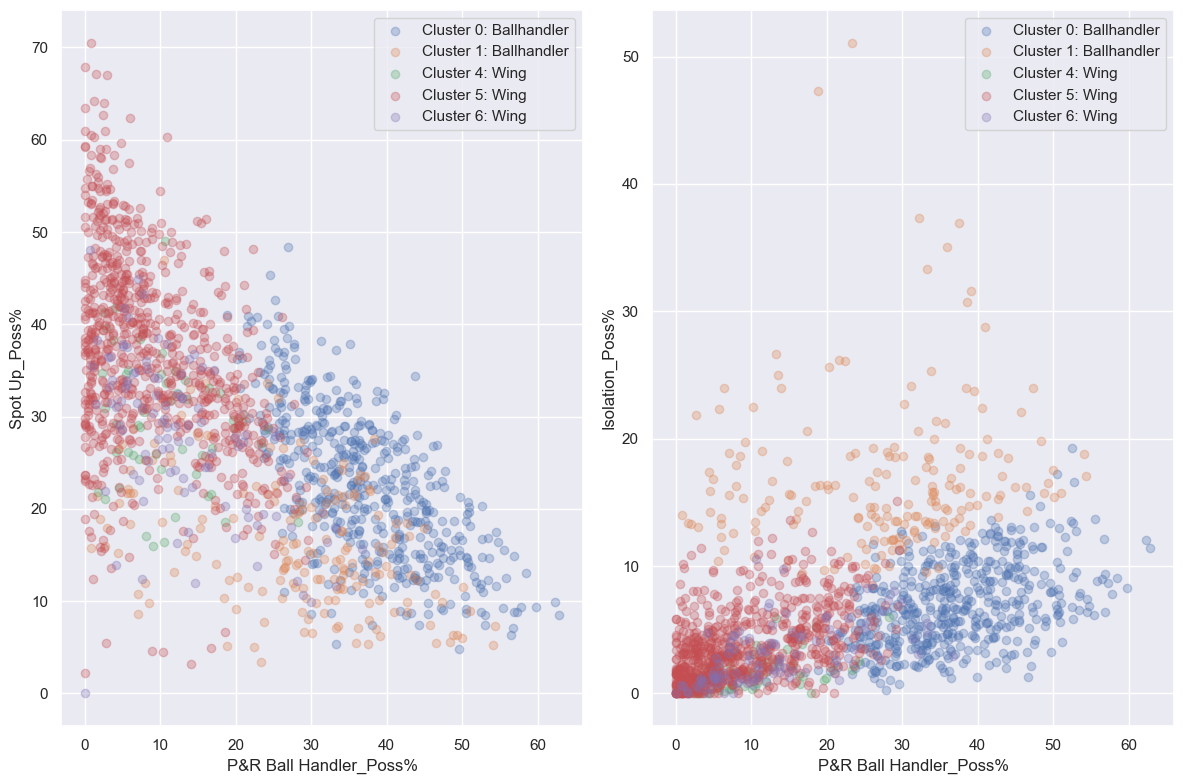

In [43]:
figsize(12, 8)
plt.subplot(1, 2, 1)
plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
                                                  for cluster in cluster_dict.keys() 
                                                  if cluster_dict[cluster] != 'Big'])], 
                    cluster_col='player_cluster', 
                    col1='P&R Ball Handler_Poss%', 
                    col2='Spot Up_Poss%',
                    cluster_dict=cluster_dict)
plt.subplot(1, 2, 2)
plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
                                                  for cluster in cluster_dict.keys() 
                                                  if cluster_dict[cluster] != 'Big'])], 
                    cluster_col='player_cluster', 
                    col1='P&R Ball Handler_Poss%', 
                    col2='Isolation_Poss%',
                    cluster_dict=cluster_dict)
plt.tight_layout()

### Distributions

In [44]:
cluster_dict

{1: 'Ballhandler',
 0: 'Ballhandler',
 2: 'Big',
 7: 'Big',
 3: 'Big',
 6: 'Wing',
 4: 'Wing',
 5: 'Wing'}

In [45]:
cluster_order = [1, 0, 6, 4, 5, 3, 2, 7]

Height & Weight

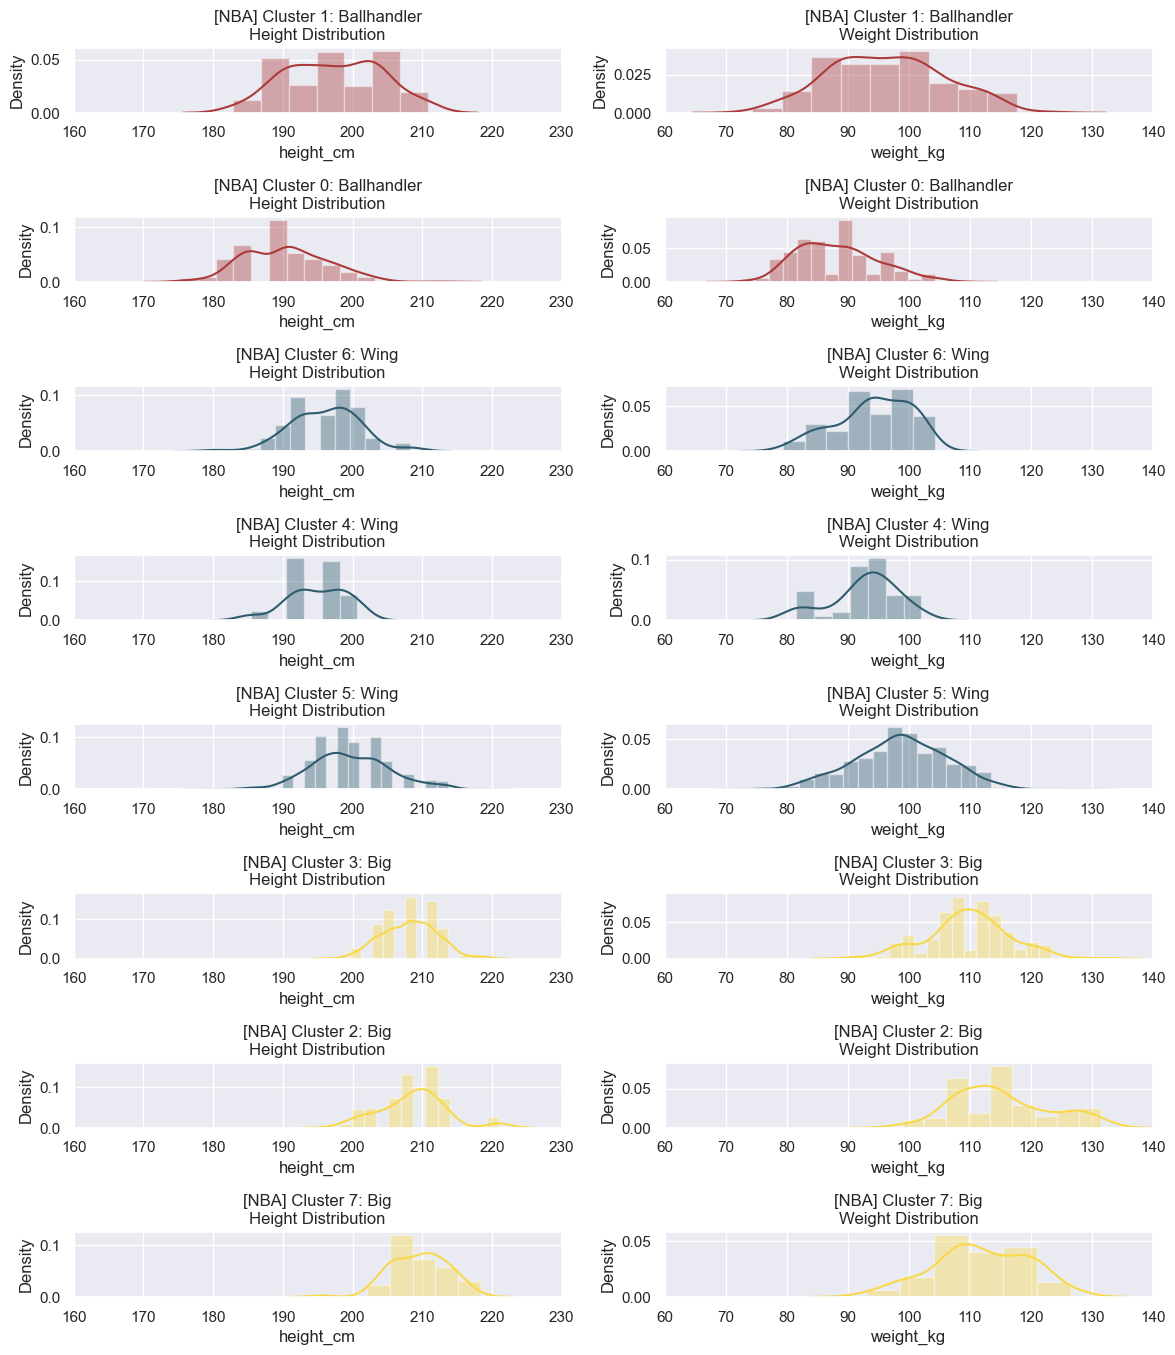

In [47]:
figsize(12, 20)
for idx, cluster in enumerate(cluster_order, 0):
    color = color_cluster(cluster)
    plt.subplot(12, 2, idx*2+1)
    sns.distplot(df[df['player_cluster'] == cluster]['height_cm'],
                 color=color)
    plt.title(f'[NBA] Cluster {cluster}: {cluster_dict[cluster]}\nHeight Distribution')
    plt.xlim(160, 230)
    plt.subplot(12, 2, idx*2+2)
    sns.distplot(df[df['player_cluster'] == cluster]['weight_kg'],
                 color=color)
    plt.title(f'[NBA] Cluster {cluster}: {cluster_dict[cluster]}\nWeight Distribution')
    plt.xlim(60, 140)
plt.tight_layout()

Usage & True Shooting

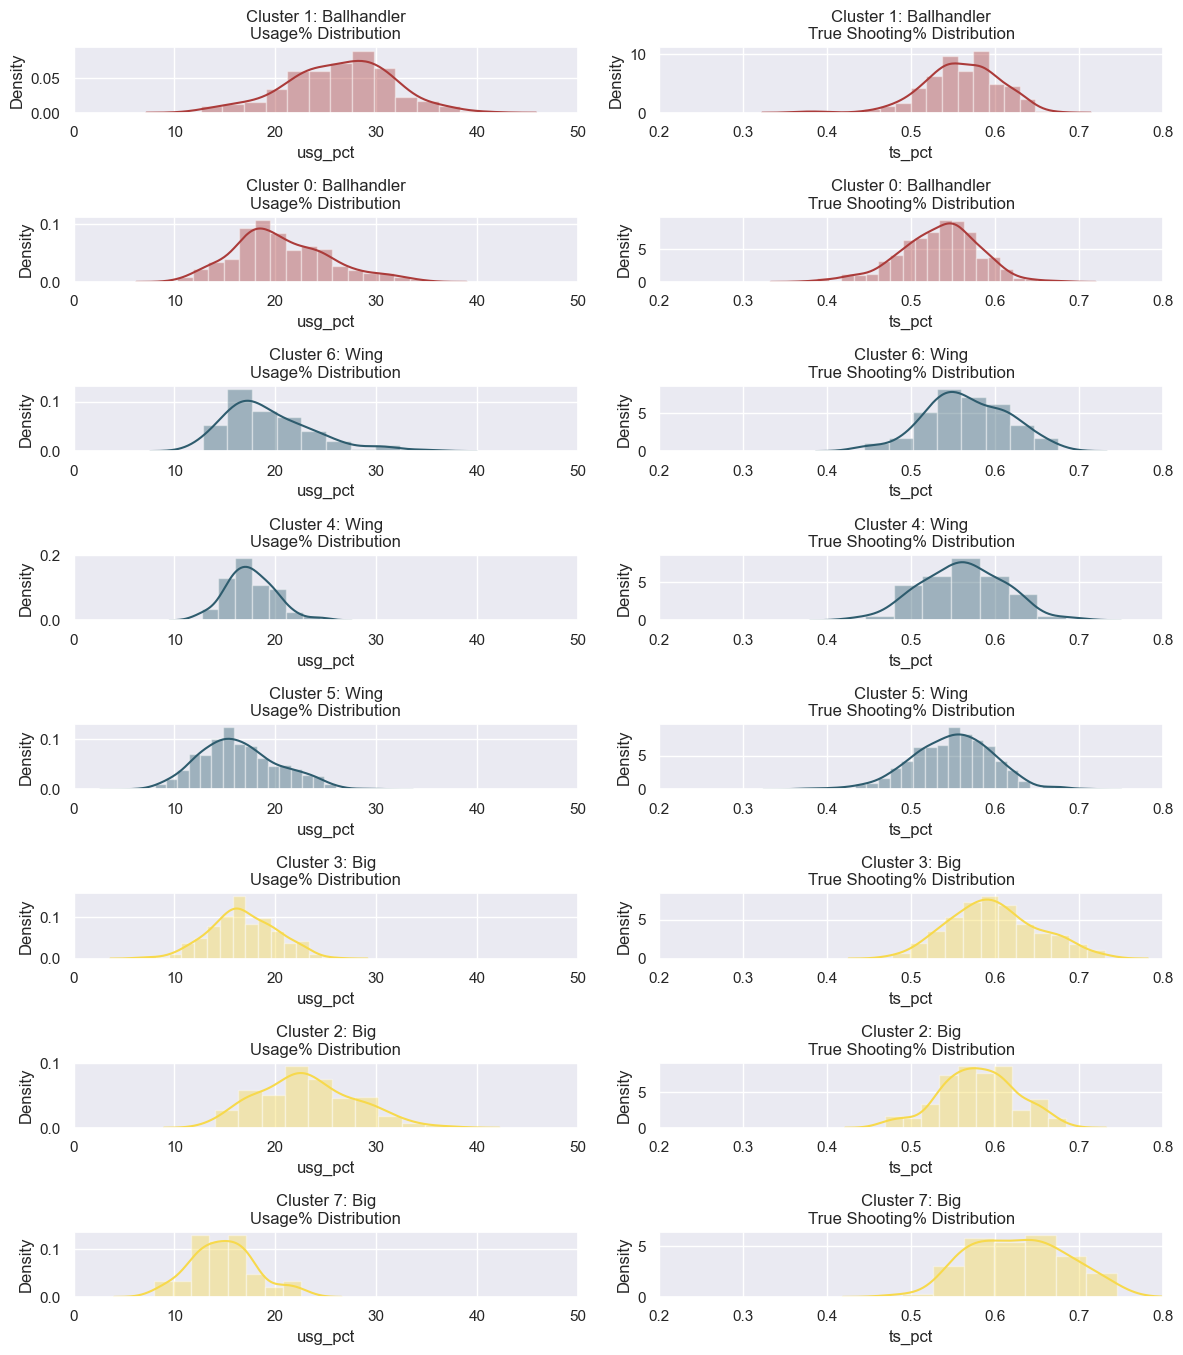

In [48]:
figsize(12, 20)
for i, cluster in enumerate(cluster_order, 0):
    color = color_cluster(cluster)
    plt.subplot(12, 2, i*2+1)
    sns.distplot(df[df['player_cluster'] == cluster]['usg_pct'],
                 color=color)
    plt.title(f'Cluster {cluster}: {cluster_dict[cluster]}\nUsage% Distribution')
    plt.xlim(0, 50)
    plt.subplot(12, 2, i*2+2)
    sns.distplot(df[df['player_cluster'] == cluster]['ts_pct'],
                 color=color)
    plt.title(f'Cluster {cluster}: {cluster_dict[cluster]}\nTrue Shooting% Distribution')
    plt.xlim(0.2, 0.8)
plt.tight_layout()

OBPM & ONPM

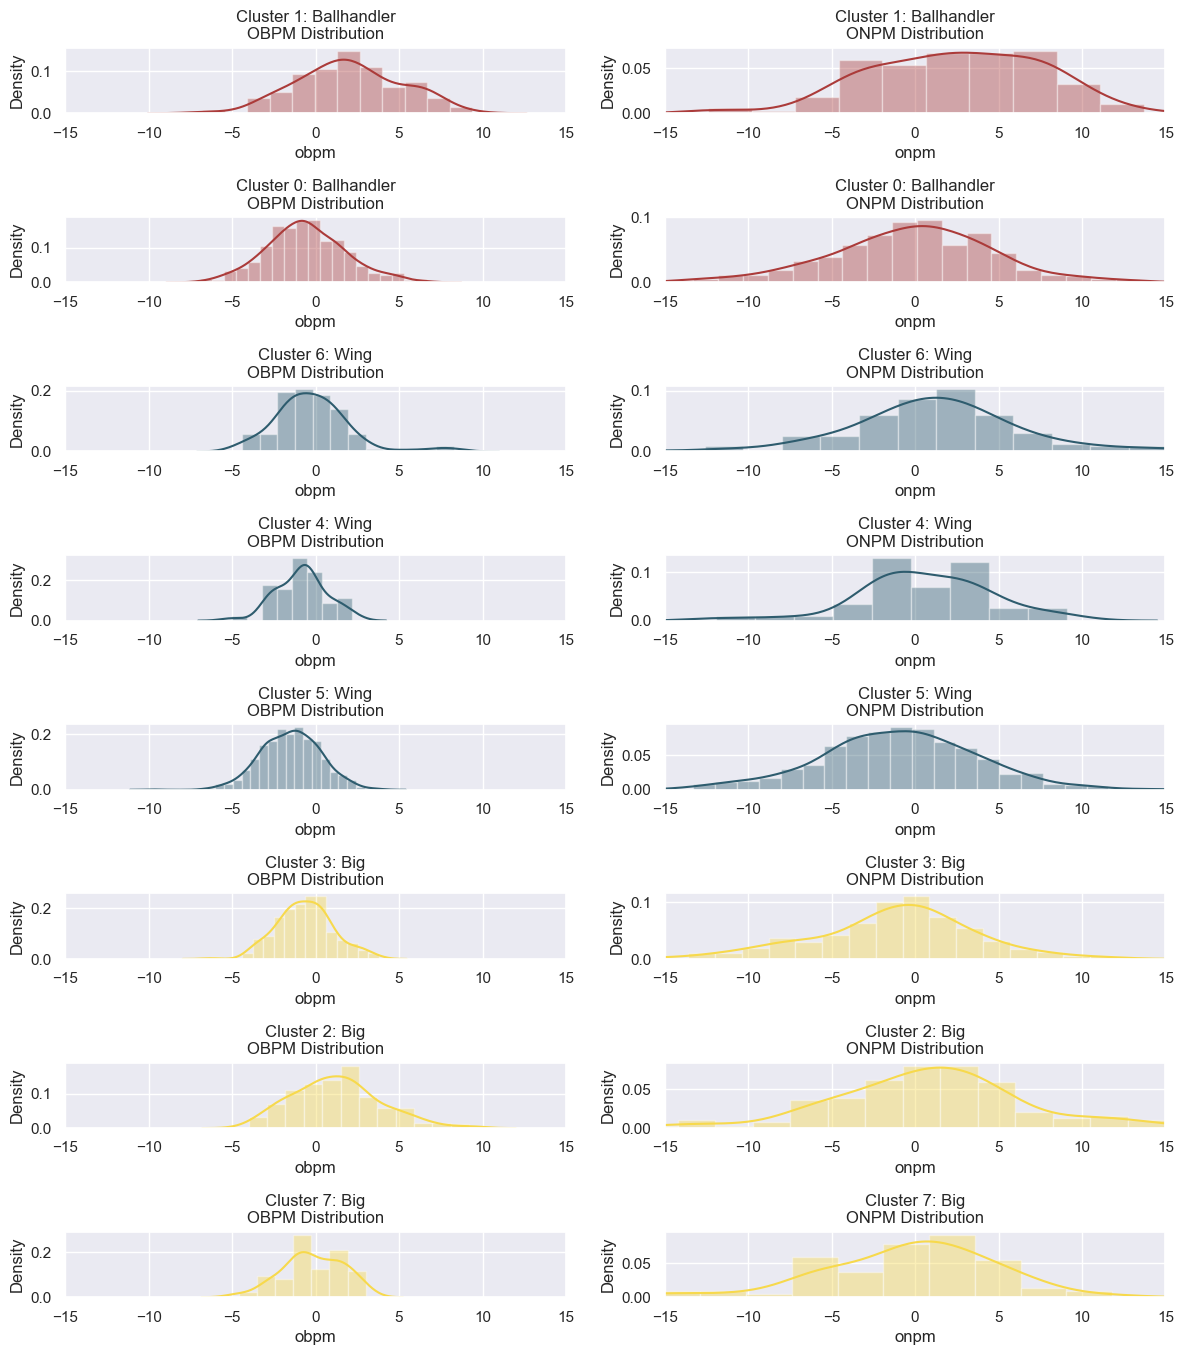

In [49]:
figsize(12, 20)
for i, cluster in enumerate(cluster_order, 0):
    color = color_cluster(cluster)
    plt.subplot(12, 2, i*2+1)
    sns.distplot(df[df['player_cluster'] == cluster]['obpm'],
                 color=color)
    plt.title(f'Cluster {cluster}: {cluster_dict[cluster]}\nOBPM Distribution')
    plt.xlim(-15, 15)
    plt.subplot(12, 2, i*2+2)
    sns.distplot(df[df['player_cluster'] == cluster]['onpm'],
                 color=color)
    plt.title(f'Cluster {cluster}: {cluster_dict[cluster]}\nONPM Distribution')
    plt.xlim(-15, 15)
plt.tight_layout()

### Top & Bottom Players by Cluster

In [147]:
def display_cluster_players(df, cluster_col, cluster_label, 
                            n=10, mp_min=600):
    cols = ['Player', 'Season', 'Team', 'obpm']
    temp = df[df['mp'] >= mp_min]
    best_10 = temp[temp[cluster_col] == cluster_label].sort_values('obpm', ascending=False)\
                                                      .head(n)[cols]\
                                                      .rename(columns={'Player': f'Best {n} Players'})\
                                                      .reset_index().drop('index', axis=1)
    worst_10 = temp[temp[cluster_col] == cluster_label].sort_values('obpm')\
                                                       .head(n)[cols]\
                                                       .rename(columns={'Player': f'Worst {n} Players'})\
                                                       .reset_index().drop('index', axis=1)
    return pd.concat([best_10, worst_10], axis=1)

Ballhandlers

In [148]:
c = 1
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 189


Best 10 Players     Season                    Team  obpm  \
0           James Harden  2018-2019         Houston Rockets   9.4   
1           James Harden  2017-2018         Houston Rockets   8.5   
2         Damian Lillard  2019-2020  Portland Trail Blazers   8.3   
3           James Harden  2019-2020         Houston Rockets   8.1   
4  Giannis Antetokounmpo  2021-2022         Milwaukee Bucks   7.6   
5         Damian Lillard  2020-2021  Portland Trail Blazers   7.5   
6            Luka Doncic  2019-2020        Dallas Mavericks   7.4   
7  Giannis Antetokounmpo  2019-2020         Milwaukee Bucks   7.4   
8           LeBron James  2017-2018     Cleveland Cavaliers   7.3   
9             Trae Young  2021-2022           Atlanta Hawks   7.1   

   Worst 10 Players     Season                    Team  obpm  
0     Austin Rivers  2018-2019      Washington Wizards  -4.1  
1     Austin Rivers  2021-2022          Denver Nuggets  -3.5  
2  Kevin Porter Jr.  2019-2020     Cleveland Cavaliers  -3.2  
3     Austin Rivers  2018-2019         Houston Rockets  -2.9  
4  Dennis Smith Jr.  2021-2022  Portland Trail Blazers  -2.8  
5   Devonte' Graham  2018-2019       Charlotte Hornets  -2.6  
6  Brandon Williams  2021-2022  Portland Trail Blazers  -2.6  
7     James Johnson  2018-2019              Miami Heat  -2.4  
8       Jeff Teague  2020-2021          Boston Celtics  -2.4  
9      Dion Waiters  2017-2018              Miami Heat  -2.1

In [149]:
c = 0
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 511


Best 10 Players     Season                Team  obpm  \
0    Kyrie Irving  2019-2020       Brooklyn Nets   6.7   
1       Ja Morant  2021-2022   Memphis Grizzlies   6.2   
2      Trae Young  2019-2020       Atlanta Hawks   6.2   
3    Jimmy Butler  2020-2021          Miami Heat   5.4   
4      Trae Young  2020-2021       Atlanta Hawks   5.3   
5    Kemba Walker  2018-2019   Charlotte Hornets   5.2   
6    Kemba Walker  2019-2020      Boston Celtics   4.9   
7     Zach Lavine  2020-2021       Chicago Bulls   4.9   
8    Bradley Beal  2020-2021  Washington Wizards   4.8   
9    Kemba Walker  2017-2018   Charlotte Hornets   4.7   

          Worst 10 Players     Season                   Team  obpm  
0            Killian Hayes  2020-2021        Detroit Pistons  -6.3  
1              Jawun Evans  2017-2018   Los Angeles Clippers  -5.4  
2              Jalen Suggs  2021-2022          Orlando Magic  -5.3  
3          Frank Ntilikina  2018-2019        New York Knicks  -5.2  
4       Aleksej Pokusevski  2020-2021  Oklahoma City Thunder  -5.1  
5             Dwayne Bacon  2017-2018      Charlotte Hornets  -4.8  
6           Chasson Randle  2020-2021          Orlando Magic  -4.8  
7             Kobi Simmons  2017-2018      Memphis Grizzlies  -4.7  
8  Michael Carter-Williams  2020-2021          Orlando Magic  -4.6  
9         Jonathon Simmons  2018-2019          Orlando Magic  -4.6

Bigs

In [150]:
c = 2
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 171


Best 10 Players     Season                    Team  obpm  \
0        Nikola Jokic  2021-2022          Denver Nuggets   9.2   
1        Nikola Jokic  2020-2021          Denver Nuggets   9.1   
2         Joel Embiid  2021-2022      Philadelphia 76ers   7.2   
3       Anthony Davis  2018-2019    New Orleans Pelicans   7.1   
4  Karl-Anthony Towns  2019-2020  Minnesota Timberwolves   7.0   
5         Joel Embiid  2020-2021      Philadelphia 76ers   6.3   
6        Nikola Jokic  2018-2019          Denver Nuggets   6.2   
7     Zion Williamson  2020-2021    New Orleans Pelicans   6.1   
8      Nikola Vucevic  2020-2021           Orlando Magic   5.5   
9        Nikola Jokic  2019-2020          Denver Nuggets   5.5   

     Worst 10 Players     Season                   Team  obpm  
0       James Wiseman  2020-2021  Golden State Warriors  -4.0  
1         Harry Giles  2018-2019       Sacramento Kings  -3.4  
2         Robin Lopez  2019-2020        Milwaukee Bucks  -3.0  
3       Dirk Nowitzki  2018-2019       Dallas Mavericks  -2.7  
4         Robin Lopez  2021-2022          Orlando Magic  -2.4  
5         Joe Johnson  2017-2018              Utah Jazz  -2.3  
6  Wendell Carter Jr.  2018-2019          Chicago Bulls  -2.2  
7     Skal Labissiere  2017-2018       Sacramento Kings  -1.9  
8       Blake Griffin  2020-2021        Detroit Pistons  -1.9  
9          Trey Lyles  2018-2019         Denver Nuggets  -1.8

In [151]:
c = 7
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 80


Best 10 Players     Season                    Team  obpm  \
0          Rudy Gobert  2018-2019               Utah Jazz   3.0   
1          Rudy Gobert  2021-2022               Utah Jazz   2.9   
2  Robert Williams III  2020-2021          Boston Celtics   2.9   
3         Clint Capela  2020-2021           Atlanta Hawks   2.7   
4        Jarrett Allen  2021-2022     Cleveland Cavaliers   2.7   
5  Robert Williams III  2021-2022          Boston Celtics   2.4   
6         Terry Taylor  2021-2022          Indiana Pacers   2.2   
7         Clint Capela  2021-2022           Atlanta Hawks   2.2   
8          Enes Kanter  2020-2021  Portland Trail Blazers   2.1   
9          Ivica Zubac  2019-2020    Los Angeles Clippers   1.9   

  Worst 10 Players     Season                   Team  obpm  
0      Ian Mahinmi  2017-2018     Washington Wizards  -4.6  
1   Daniel Gafford  2019-2020          Chicago Bulls  -2.8  
2    Zaza Pachulia  2018-2019        Detroit Pistons  -2.8  
3   Tyson Chandler  2018-2019     Los Angeles Lakers  -2.7  
4       Khem Birch  2019-2020          Orlando Magic  -2.5  
5   Isaiah Stewart  2021-2022        Detroit Pistons  -2.5  
6     Nerlens Noel  2020-2021        New York Knicks  -2.4  
7   Onyeka Okongwu  2020-2021          Atlanta Hawks  -2.2  
8    Dwight Howard  2020-2021     Philadelphia 76ers  -2.1  
9     Kevon Looney  2020-2021  Golden State Warriors  -1.8

In [156]:
c = 3
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 256


Best 10 Players     Season                    Team  obpm  \
0      John Collins  2019-2020           Atlanta Hawks   3.7   
1        Al Horford  2018-2019          Boston Celtics   3.3   
2      Clint Capela  2018-2019         Houston Rockets   3.3   
3    Brandon Clarke  2021-2022       Memphis Grizzlies   3.1   
4     Thomas Bryant  2019-2020      Washington Wizards   2.9   
5       Bam Adebayo  2020-2021              Miami Heat   2.9   
6      John Collins  2018-2019           Atlanta Hawks   2.8   
7     Chris Boucher  2020-2021         Toronto Raptors   2.7   
8  Hassan Whiteside  2019-2020  Portland Trail Blazers   2.5   
9      Clint Capela  2017-2018         Houston Rockets   2.4   

   Worst 10 Players     Season                   Team  obpm  
0       Isaiah Roby  2020-2021  Oklahoma City Thunder  -3.7  
1     Miles Plumlee  2017-2018          Atlanta Hawks  -3.7  
2       Aron Baynes  2017-2018         Boston Celtics  -3.6  
3  Precious Achiuwa  2020-2021             Miami Heat  -3.6  
4   Bismack Biyombo  2020-2021      Charlotte Hornets  -3.4  
5       Aron Baynes  2020-2021        Toronto Raptors  -3.4  
6          Alex Len  2021-2022       Sacramento Kings  -3.2  
7    Bruno Fernando  2019-2020          Atlanta Hawks  -3.2  
8        Mike Scott  2020-2021     Philadelphia 76ers  -3.2  
9        Taj Gibson  2021-2022        New York Knicks  -3.0

Wings

In [157]:
c = 6
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 101


Best 10 Players     Season                   Team  obpm Worst 10 Players  \
0      Stephen Curry  2020-2021  Golden State Warriors   8.3     Jordan Poole   
1      Stephen Curry  2017-2018  Golden State Warriors   7.8   Justin Holiday   
2      Stephen Curry  2018-2019  Golden State Warriors   7.1        Ian Clark   
3      Stephen Curry  2021-2022  Golden State Warriors   5.4     Ben McLemore   
4  Bogdan Bogdanovic  2020-2021          Atlanta Hawks   3.3     Allen Crabbe   
5      Davis Bertans  2019-2020     Washington Wizards   2.7    Darius Miller   
6    Otto Porter Jr.  2017-2018     Washington Wizards   2.6         JR Smith   
7      Klay Thompson  2021-2022  Golden State Warriors   2.6  Wesley Matthews   
8        Buddy Hield  2019-2020       Sacramento Kings   2.5    E'Twaun Moore   
9          JJ Redick  2019-2020   New Orleans Pelicans   2.3    Landry Shamet   

      Season                   Team  obpm  
0  2019-2020  Golden State Warriors  -4.4  
1  2018-2019      Memphis Grizzlies  -3.3  
2  2018-2019   New Orleans Pelicans  -3.3  
3  2017-2018      Memphis Grizzlies  -2.9  
4  2018-2019          Brooklyn Nets  -2.4  
5  2018-2019   New Orleans Pelicans  -2.1  
6  2017-2018    Cleveland Cavaliers  -2.1  
7  2018-2019         Indiana Pacers  -2.0  
8  2019-2020   New Orleans Pelicans  -1.9  
9  2019-2020   Los Angeles Clippers  -1.8

In [158]:
c = 4
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 50


Best 10 Players     Season                Team  obpm Worst 10 Players  \
0        JJ Redick  2017-2018  Philadelphia 76ers   2.2      Gary Harris   
1        JJ Redick  2018-2019  Philadelphia 76ers   2.2    Terrence Ross   
2  Duncan Robinson  2019-2020          Miami Heat   1.5    Avery Bradley   
3   Doug McDermott  2020-2021      Indiana Pacers   1.4   Justin Holiday   
4   Doug McDermott  2019-2020      Indiana Pacers   1.4    Armoni Brooks   
5  Wayne Ellington  2020-2021     Detroit Pistons   1.1    Terrence Ross   
6      Gary Harris  2017-2018      Denver Nuggets   1.0  Rodney McGruder   
7  Wayne Ellington  2017-2018          Miami Heat   1.0      Gary Harris   
8   Reggie Bullock  2017-2018     Detroit Pistons   0.7     Troy Daniels   
9  Wayne Ellington  2018-2019     Detroit Pistons   0.0   Justin Holiday   

      Season              Team  obpm  
0  2019-2020    Denver Nuggets  -2.8  
1  2017-2018     Orlando Magic  -2.8  
2  2017-2018   Detroit Pistons  -2.8  
3  2021-2022  Sacramento Kings  -2.6  
4  2021-2022   Houston Rockets  -2.6  
5  2021-2022     Orlando Magic  -2.5  
6  2018-2019        Miami Heat  -2.2  
7  2021-2022     Orlando Magic  -2.0  
8  2018-2019      Phoenix Suns  -1.7  
9  2017-2018     Chicago Bulls  -1.6

In [159]:
c = 5
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 782


Best 10 Players     Season                Team  obpm   Worst 10 Players  \
0  Michael Porter Jr.  2020-2021      Denver Nuggets   4.0       Dwayne Bacon   
1      Christian Wood  2019-2020     Detroit Pistons   3.5     Tyrone Wallace   
2         Buddy Hield  2018-2019    Sacramento Kings   3.5        Paul Zipser   
3        Jaylen Brown  2020-2021      Boston Celtics   3.2    Sekou Doumbouya   
4       Tobias Harris  2020-2021  Philadelphia 76ers   2.9          PJ Tucker   
5        Kelly Olynyk  2020-2021     Houston Rockets   2.9        Rodney Hood   
6        Desmond Bane  2021-2022   Memphis Grizzlies   2.5    Sekou Doumbouya   
7       Mikal Bridges  2020-2021        Phoenix Suns   2.4     Treveon Graham   
8        Terry Rozier  2021-2022   Charlotte Hornets   2.4       Lance Thomas   
9  Michael Porter Jr.  2019-2020      Denver Nuggets   2.4  Terrance Ferguson   

      Season                    Team  obpm  
0  2019-2020       Charlotte Hornets  -5.9  
1  2018-2019    Los Angeles Clippers  -5.6  
2  2017-2018           Chicago Bulls  -5.5  
3  2020-2021         Detroit Pistons  -5.4  
4  2020-2021         Houston Rockets  -5.3  
5  2020-2021  Portland Trail Blazers  -5.3  
6  2019-2020         Detroit Pistons  -5.2  
7  2019-2020  Minnesota Timberwolves  -5.0  
8  2018-2019         New York Knicks  -4.8  
9  2019-2020   Oklahoma City Thunder  -4.8

### Edge Cases

In [117]:
temp = df.groupby('Player')['player_cluster'].apply(list).reset_index()
temp['player_cluster_adj'] = temp['player_cluster'].apply(lambda x: [cluster_dict[s] 
                                                                     for s in x])\
                                                   .apply(set)
temp['player_cluster'] = temp['player_cluster'].apply(set)
temp['n_cluster'] = temp['player_cluster_adj'].apply(len)
temp[temp['n_cluster'] == 3]

Player player_cluster        player_cluster_adj  n_cluster
140  DeMarcus Cousins      {1, 2, 5}  {Ballhandler, Big, Wing}          3
230   Harrison Barnes      {1, 2, 5}  {Ballhandler, Big, Wing}          3
282     James Johnson      {1, 3, 5}  {Ballhandler, Big, Wing}          3
304      Jerami Grant      {1, 3, 5}  {Ballhandler, Big, Wing}          3
444     Marcus Morris      {1, 2, 5}  {Ballhandler, Big, Wing}          3

In [106]:
temp[(temp['n_cluster'] == 2) & 
     (temp['player_cluster_adj'] == set(['Ballhandler', 'Big']))]

Player player_cluster  player_cluster_adj  n_cluster
79      Carmelo Anthony         {1, 2}  {Ballhandler, Big}          2
116    Danilo Gallinari         {1, 2}  {Ballhandler, Big}          2
231         Harry Giles      {1, 2, 3}  {Ballhandler, Big}          2
358       Julius Randle         {1, 2}  {Ballhandler, Big}          2
367  Karl-Anthony Towns         {1, 2}  {Ballhandler, Big}          2

In [160]:
df[df['Player'].str.contains('Bismack')]

Player               Team     Season  GP    FGM    FGA  \
189   Bismack Biyombo  Charlotte Hornets  2018-2019  54   89.0  155.0   
199   Bismack Biyombo  Charlotte Hornets  2019-2020  53  151.0  278.0   
212   Bismack Biyombo  Charlotte Hornets  2020-2021  66  142.0  245.0   
1196  Bismack Biyombo      Orlando Magic  2017-2018  82  183.0  350.0   
2037  Bismack Biyombo       Phoenix Suns  2021-2022  36   86.0  146.0   

      Catch and Shoot_FGM  Catch and Shoot_FGA  Catch and Shoot_FG%  \
189                   0.0                  8.0             0.000000   
199                   1.0                  4.0             0.250000   
212                   0.0                  1.0             0.000000   
1196                  8.0                 29.0             0.275862   
2037                  0.0                  0.0             0.000000   

      Catch and Shoot_FGA%  At Rim_FGM  At Rim_FGA  At Rim_FG%  At Rim_FGA%  \
189               0.051613        69.0       108.0    0.638889     0.696774   
199               0.014388       120.0       191.0    0.628272     0.687050   
212               0.004082       120.0       191.0    0.628272     0.779592   
1196              0.082857       141.0       221.0    0.638009     0.631429   
2037              0.000000        65.0        93.0    0.698925     0.636986   

      Long (3 point jump shots)_FGM  Long (3 point jump shots)_FGA  \
189                             0.0                            0.0   
199                             0.0                            0.0   
212                             0.0                            1.0   
1196                            0.0                            0.0   
2037                            0.0                            0.0   

      Long (3 point jump shots)_FG%  Long (3 point jump shots)_FGA%  \
189                             0.0                        0.000000   
199                             0.0                        0.000000   
212                             0.0                        0.004082   
1196                            0.0                        0.000000   
2037                            0.0                        0.000000   

      All Jump Shots off the Dribble_FGM  All Jump Shots off the Dribble_FGA  \
189                                  2.0                                 2.0   
199                                  0.0                                 1.0   
212                                  0.0                                 1.0   
1196                                 0.0                                 4.0   
2037                                 0.0                                 0.0   

      All Jump Shots off the Dribble_FG%  All Jump Shots off the Dribble_FGA%  \
189                                  1.0                             0.012903   
199                                  0.0                             0.003597   
212                                  0.0                             0.004082   
1196                                 0.0                             0.011429   
2037                                 0.0                             0.000000   

      Isolation_Poss  Isolation_PPP  P&R Ball Handler_Poss  \
189              0.0            0.0                    0.0   
199              0.0            0.0                    0.0   
212              0.0            0.0                    0.0   
1196             0.0            0.0                    0.0   
2037             1.0            0.0                    0.0   

      P&R Ball Handler_PPP  Post-Up_Poss  Post-Up_PPP  P&R Roll Man_Poss  \
189                    0.0           3.0        0.667               72.0   
199                    0.0          17.0        1.000               98.0   
212                    0.0          16.0        0.438               62.0   
1196                   0.0          23.0        0.522              122.0   
2037                   0.0          21.0        0.905               65.0   

      P&R Roll Man_PPP  Spot

## Visualization via TSNE

In [61]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.2.1.


Changed in version 1.2: The default value changed to "pca".  
https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE

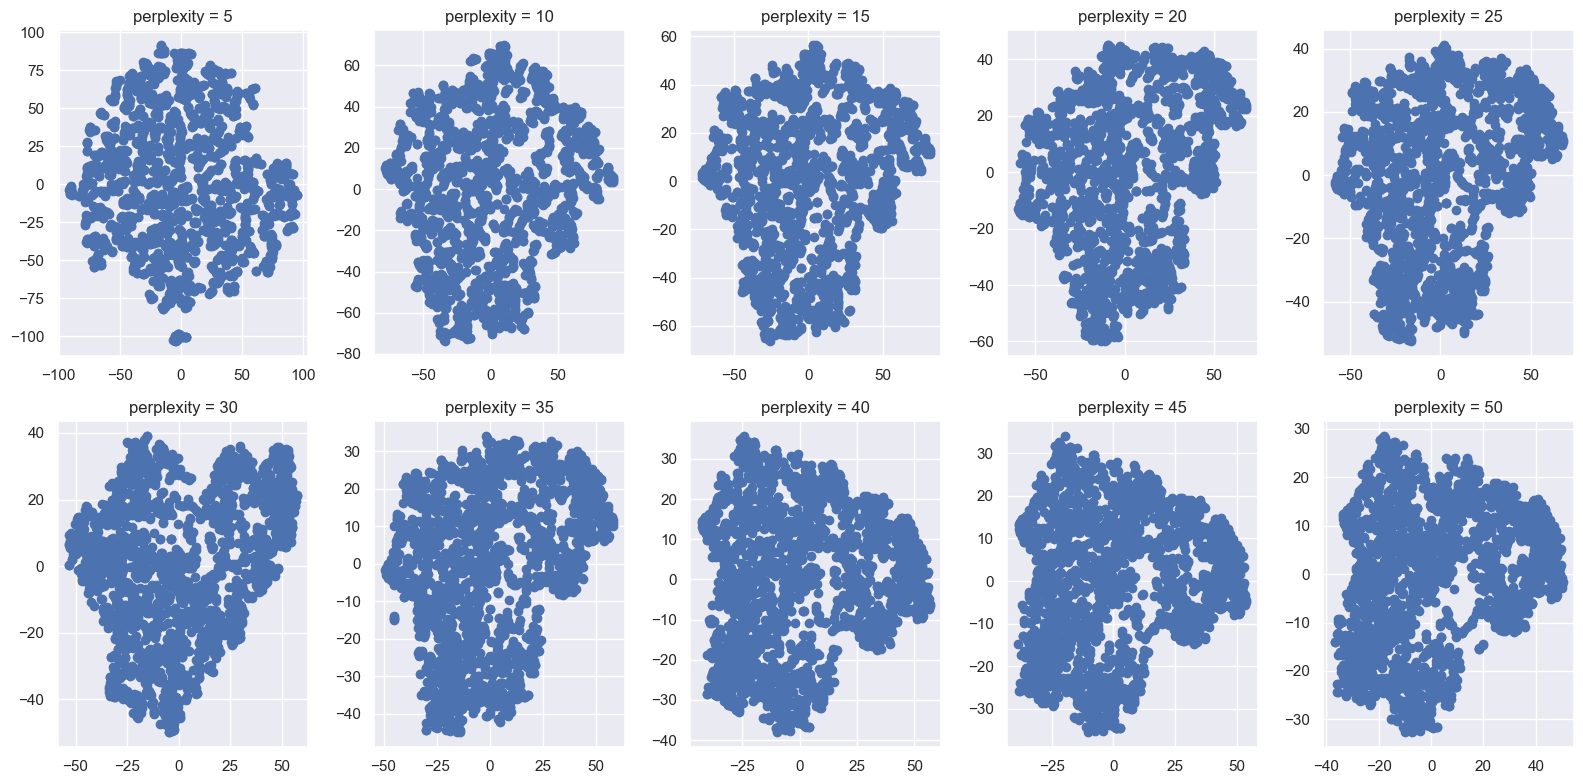

In [62]:
figsize(16, 8)
for i in list(range(1, 11)):
    plt.subplot(2, 5, i)
    perplexity = 5 * i
    tsne = TSNE(perplexity=perplexity, 
#                 early_exaggeration=4,
                init='random',
                random_state=42)
    X_tsne = tsne.fit_transform(X_transformed)
    plt.scatter(X_tsne[:,0], X_tsne[:, 1])
    plt.title(f'perplexity = {perplexity}')
plt.tight_layout()

In [63]:
perplexity = 20
tsne = TSNE(perplexity=perplexity, 
#             early_exaggeration=4,
            init='random',
            random_state=42)
X_tsne = tsne.fit_transform(X_transformed)

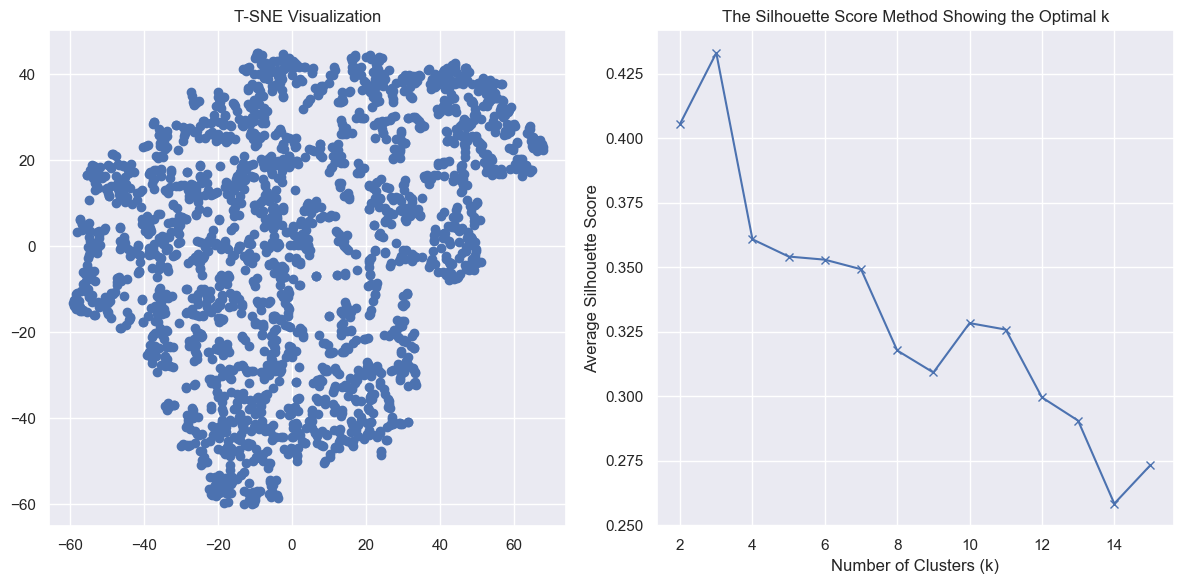

In [64]:
figsize(12, 6)
plt.subplot(1, 2, 1)
plt.scatter(X_tsne[:,0], X_tsne[:, 1])
plt.title('T-SNE Visualization')
plt.subplot(1, 2, 2)
plot_silhouette_score(X_tsne)
plt.tight_layout()

In [65]:
df_tsne = df.copy()
n_clusters_tsne = 3

sc_tsne = SpectralClustering(n_clusters=n_clusters_tsne, 
                             affinity='nearest_neighbors', 
                             random_state=42)
sc_tsne.fit(X_tsne)
df_tsne['cluster_label_tsne'] = sc_tsne.labels_

In [66]:
upper_limit = 60
lower_limit = -120
loc = 'lower right'

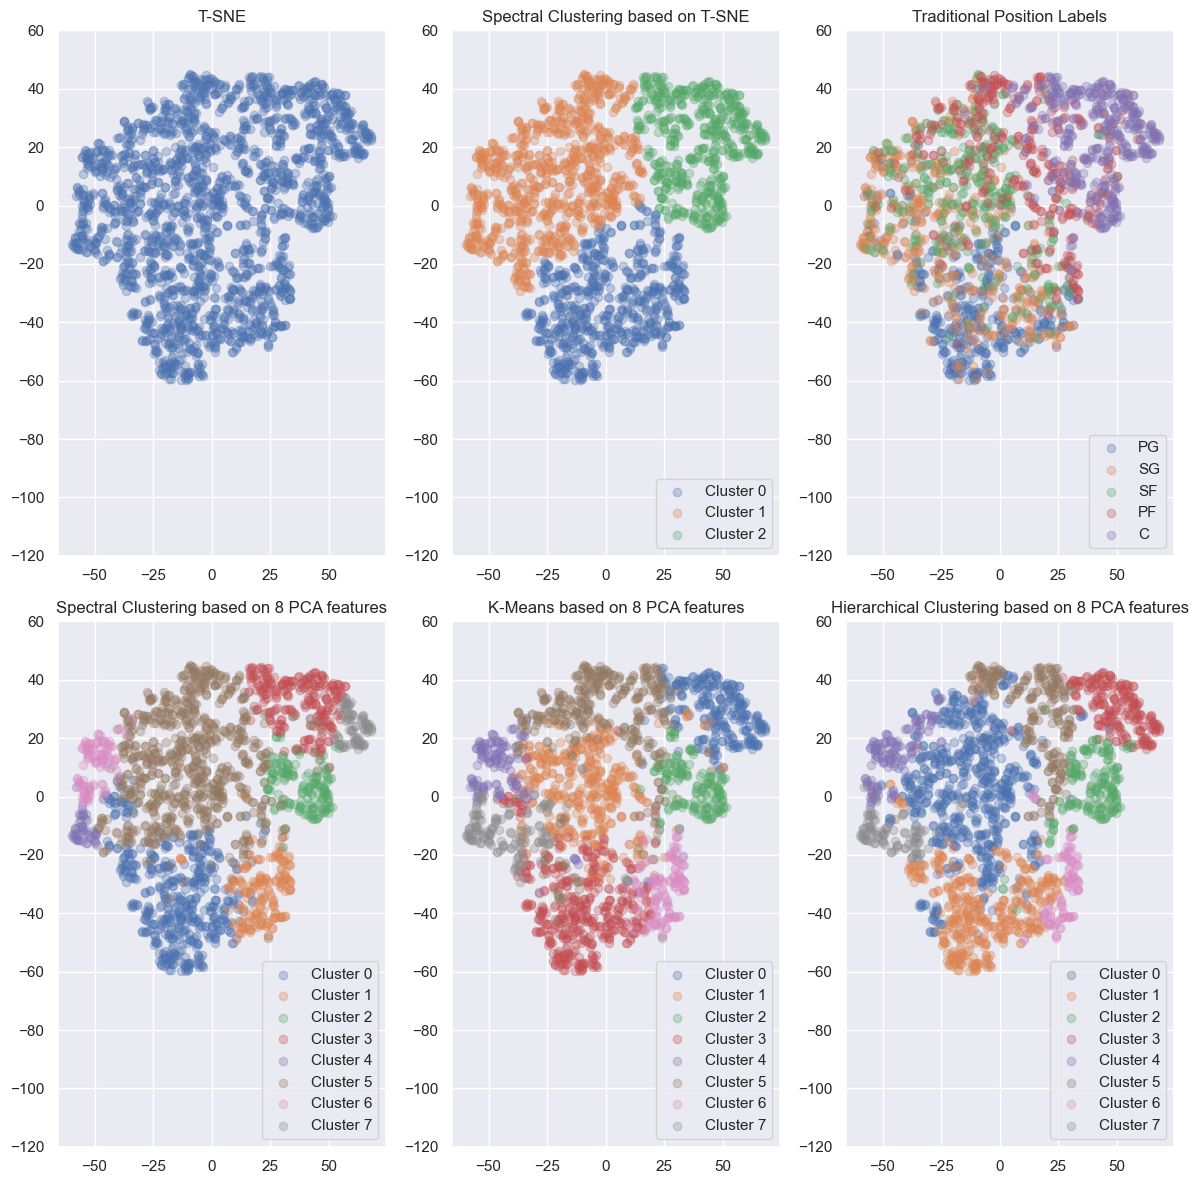

In [67]:
figsize(12, 12)

plt.subplot(2, 3, 1)
plt.scatter(X_tsne[:,0], X_tsne[:, 1], alpha=0.3)
plt.title('T-SNE')
plt.ylim(lower_limit, upper_limit)

plt.subplot(2, 3, 2)
for i in range(n_clusters_tsne):
    cluster_cond = df_tsne['cluster_label_tsne'] == i
    cluster_index = df_tsne[cluster_cond].index
    plt.scatter(X_tsne[cluster_index, 0], 
                X_tsne[cluster_index, 1], 
                label=f'Cluster {i}', 
                alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title('Spectral Clustering based on T-SNE')

plt.subplot(2, 3, 3)
for idx, pos in enumerate(['PG', 'SG', 'SF', 'PF', 'C'], 1):
    pos_cond = df['pos'] == pos
    pos_index = df[pos_cond].index
    plt.scatter(X_tsne[pos_index, 0], 
                X_tsne[pos_index, 1], 
                label=pos, 
                alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title('Traditional Position Labels')

plt.subplot(2, 3, 4)
sc = SpectralClustering(n_clusters=n_clusters, 
                        affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], 
                X_tsne[cluster_index, 1], 
                label=f'Cluster {i}', 
                alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title(f'Spectral Clustering based on {n_components} PCA features')

plt.subplot(2, 3, 5)
km = KMeans(n_clusters=n_clusters, random_state=42)
labels = km.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], 
                X_tsne[cluster_index, 1], 
                label=f'Cluster {i}', 
                alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title(f'K-Means based on {n_components} PCA features')

plt.subplot(2, 3, 6)
agc = AgglomerativeClustering(n_clusters=n_clusters, 
                              affinity='euclidean',
                              linkage='ward')
labels = agc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], 
                X_tsne[cluster_index, 1], 
                label=f'Cluster {i}', 
                alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title(f'Hierarchical Clustering based on {n_components} PCA features')

plt.tight_layout()

Text(0.5, 1.0, 'Spectral Clustering based on 8 PCA features')

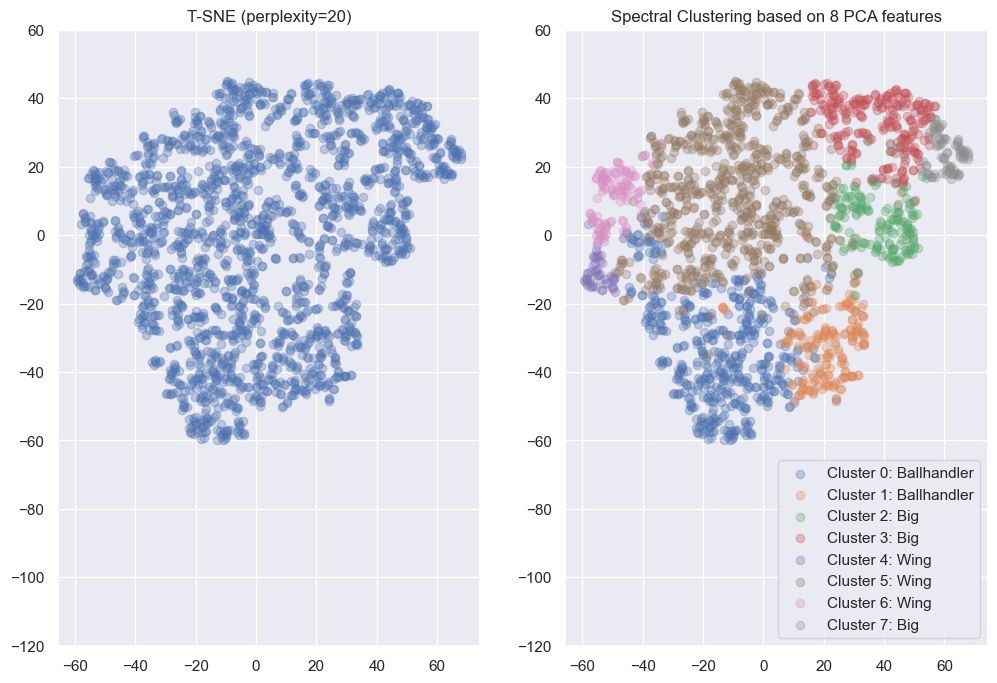

In [68]:
figsize(12, 8)

plt.subplot(1, 2, 1)
plt.scatter(X_tsne[:,0], X_tsne[:, 1], alpha=0.3)
plt.title(f'T-SNE (perplexity={perplexity})')
plt.ylim(lower_limit, upper_limit)

plt.subplot(1, 2, 2)
sc = SpectralClustering(n_clusters=n_clusters, 
                        affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], 
                X_tsne[cluster_index, 1], 
                label=f'Cluster {i}: {cluster_dict[i]}', 
                alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title(f'Spectral Clustering based on {n_components} PCA features')

Text(0.5, 1.0, 'Spectral Clustering based on 8 PCA features')

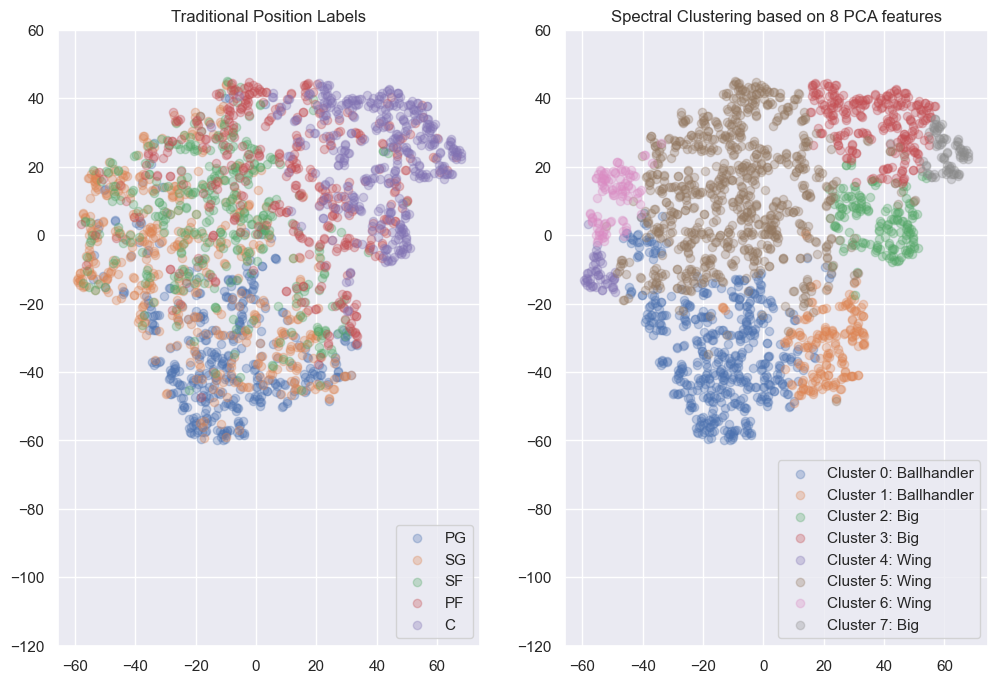

In [69]:
figsize(12, 8)

plt.subplot(1, 2, 1)
for idx, pos in enumerate(['PG', 'SG', 'SF', 'PF', 'C'], 1):
    pos_cond = df['pos'] == pos
    pos_index = df[pos_cond].index
    plt.scatter(X_tsne[pos_index, 0], 
                X_tsne[pos_index, 1], 
                label=pos, 
                alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title('Traditional Position Labels')

plt.subplot(1, 2, 2)
sc = SpectralClustering(n_clusters=n_clusters, 
                        affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], 
                X_tsne[cluster_index, 1], 
                label=f'Cluster {i}: {cluster_dict[i]}', 
                alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title(f'Spectral Clustering based on {n_components} PCA features')

Text(0.5, 1.0, 'Spectral Clustering based on 8 PCA features\n[NBA]')

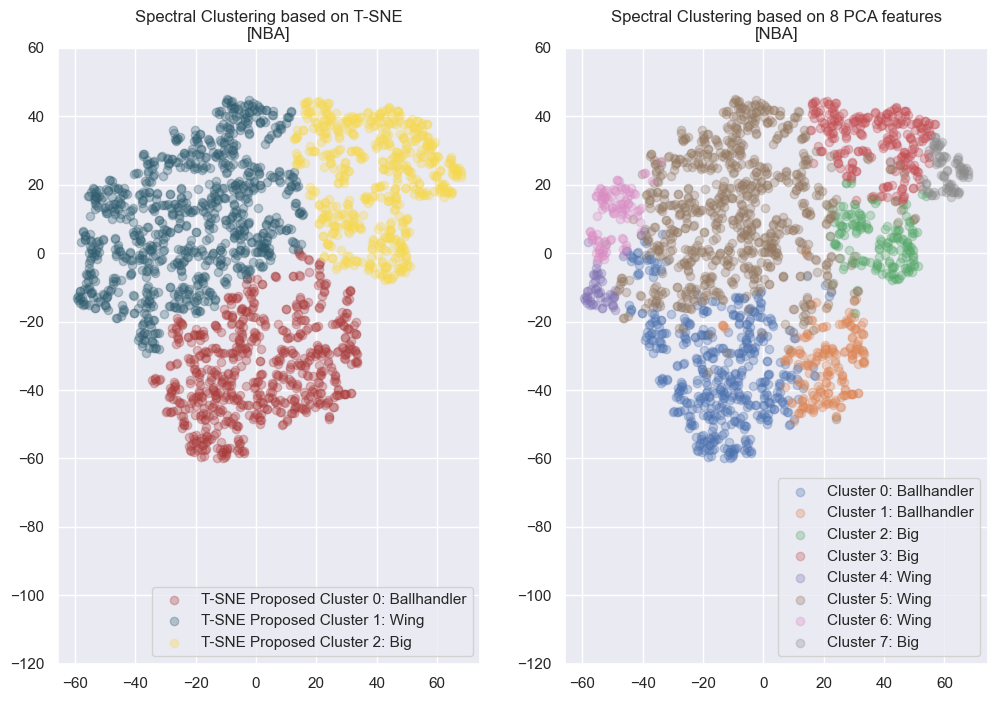

In [75]:
figsize(12, 8)

tsne_proposed_clusters = {0: 'Ballhandler',
                          1: 'Wing',
                          2: 'Big'}

plt.subplot(1, 2, 1)
for i in range(n_clusters_tsne):
    cluster_cond = df_tsne['cluster_label_tsne'] == i
    cluster_index = df_tsne[cluster_cond].index
    plt.scatter(X_tsne[cluster_index, 0], 
                X_tsne[cluster_index, 1], 
                label=f'T-SNE Proposed Cluster {i}: {tsne_proposed_clusters[i]}', 
                color=color_cluster(i, tsne_proposed_clusters),
                alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title('Spectral Clustering based on T-SNE\n[NBA]')

plt.subplot(1, 2, 2)
sc = SpectralClustering(n_clusters=n_clusters, 
                        affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], 
                X_tsne[cluster_index, 1], 
                label=f'Cluster {i}: {cluster_dict[i]}', 
                alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title(f'Spectral Clustering based on {n_components} PCA features\n[NBA]')

In [71]:
cluster_map_km_to_sc = {7: 4, 
                        4: 6, 
                        5: 3, 
                        1: 5, 
                        6: 1, 
                        0: 7, 
                        3: 0,
                        2: 2}

(-120.0, 60.0)

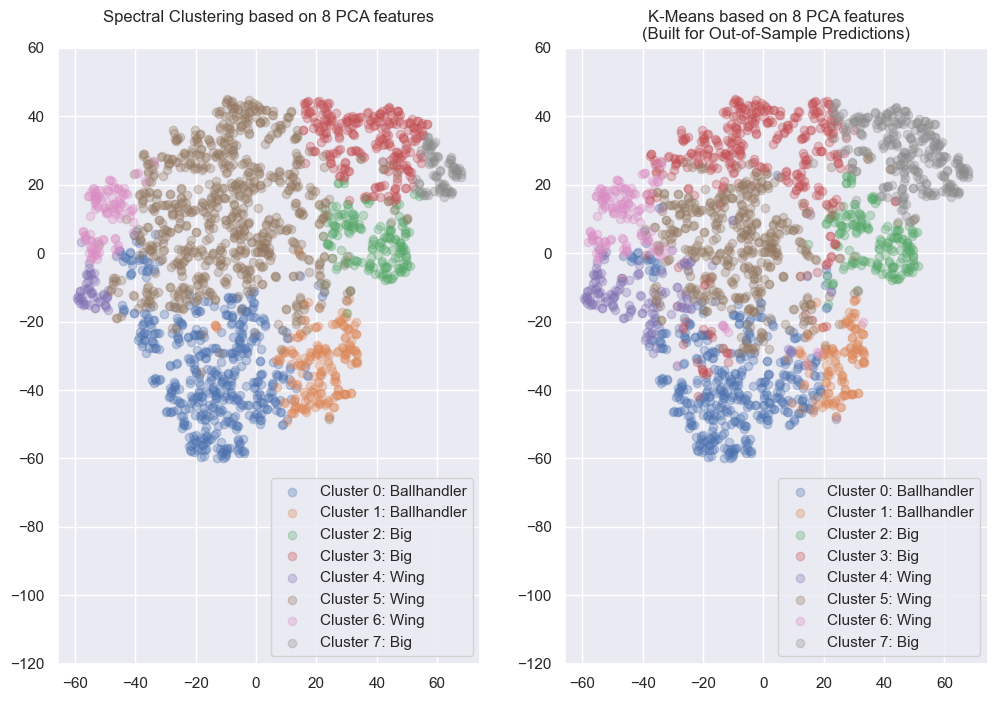

In [72]:
figsize(12, 8)

plt.subplot(1, 2, 1)
sc = SpectralClustering(n_clusters=n_clusters, 
                        affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], 
                X_tsne[cluster_index, 1], 
                label=f'Cluster {i}: {cluster_dict[i]}', alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title(f'Spectral Clustering based on {n_components} PCA features\n')

plt.subplot(1, 2, 2)
km = KMeans(n_clusters=n_clusters, random_state=42)
labels = km.fit_predict(X_transformed)
labels = [cluster_map_km_to_sc[label] for label in labels]
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], 
                X_tsne[cluster_index, 1], 
                label=f'Cluster {i}: {cluster_dict[i]}', alpha=0.3)
oos = '(Built for Out-of-Sample Predictions)'
plt.title(f'K-Means based on {n_components} PCA features\n{oos}')
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)

## Save Models

In [71]:
df.to_csv('nba_cleaned.csv', index=False)

In [72]:
nba_clustering_models = {'pre_pca_pipe': pre_pca_pipe,
                         'pca': pca,
                         'pre_cluster_scaler': pre_cluster_scaler,
                         'cluster_dict': cluster_dict}
dump_pickle(nba_clustering_models, 'nba_clustering_models')

In [73]:
nba_clustering_models_km = {'pre_pca_pipe': pre_pca_pipe,
                            'pca': pca,
                            'pre_cluster_scaler': pre_cluster_scaler,
                            'cluster_map_to_spectral_clustering': cluster_map_km_to_sc,
                            'km': km}
dump_pickle(nba_clustering_models_km, 'nba_clustering_models_km')